# NSF Mathematical and Physical Sciences (MPS)

- `0302****`: Division of Astronomical Sciences (AST)
- `0309****`: Division of Chemistry (CHE) 
- `0307****`: Division of Materials Research (DMR) 
- `0304****`: Division of Mathematical Sciences (DMS) 
- `0301****`: Division of Physics (PHY)

In [1]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [2]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "0302": "Division of Astronomical Sciences (AST)",
    "0309": "Division of Chemistry (CHE)",
    "0307": "Division of Materials Research (DMR)",
    "0304": "Division of Mathematical Sciences (DMS)",
    "0301": "Division of Physics (PHY)",
}

In [3]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"][:4] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [4]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Astronomical Sciences (AST) 172
Division of Chemistry (CHE) 466
Division of Materials Research (DMR) 441
Division of Mathematical Sciences (DMS) 880
Division of Physics (PHY) 261


Counter({1: 1560, 2: 345, 3: 116, 5: 103, 4: 73, 6: 11, 0: 9, 7: 2, 8: 1})


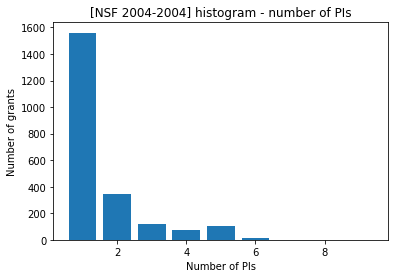

In [5]:
histogram_num_pis(data, years, div_type.keys())

In [6]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0400363', '0400369', '0400383', '0400481', '0400512', '0400832', '0400866', '0400880', '0400960', '0400966', '0401175', '0401244', '0401275', '0401302', '0401469', '0401526', '0401613', '0401670', '0402276', '0402502', '0402849', '0403004', '0403575', '0404507', '0404575', '0404577', '0404579', '0404630', '0404729', '0404806', '0404853', '0404931', '0404952', '0404991', '0405038', '0405057', '0405082', '0405105', '0405136', '0405208', '0405299', '0405345', '0405376', '0405491', '0405532', '0405543', '0405620', '0405628', '0405716', '0405825', '0405853', '0405874', '0405927', '0405931', '0406016', '0406049', '0406115', '0406174', '0406220', '0406287', '0406302', '0406339', '0406361', '0406493', '0406563', '0406615', '0406724', '0406816', '0406837', '0406841', '0406865', '0406884', '0406958', '0406991', '0407061', '0407073', '0407134', '0407176', '0407207', '0407270', '0407298', '0407418', '0407517', '0407840', '0407946', '0407958', '0408086', '0408102', '0408211', '0408226', '0408230'

In [7]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

345 grants with 2 PIs


In [8]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    if pid in ["0457035", "0457336"]:
        continue
    try:
        award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    except:
        continue
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0400363 union=2, max_group=2, numpub=11 60 50
0400369 union=2, max_group=2, numpub=103 103 48
0400481 union=2, max_group=2, numpub=14 16 3
0400512 union=2, max_group=1, numpub=12 12 0
0400832 union=1, max_group=1, numpub=2 2 0
0400866 union=1, max_group=1, numpub=19 19 0
0400880 union=3, max_group=2, numpub=7 24 21
0400960 union=1, max_group=1, numpub=6 6 0
0400966 union=2, max_group=2, numpub=8 66 62
0401175 union=2, max_group=2, numpub=4 12 11
0401275 union=1, max_group=1, numpub=1 1 0
0401302 union=2, max_group=2, numpub=18 40 25
0401526 union=2, max_group=2, numpub=3 6 5
0401613 union=3, max_group=2, numpub=8 13 7
0401670 union=2, max_group=1, numpub=4 4 0
0402276 union=2, max_group=2, numpub=9 36 29
0402502 union=2, max_group=2, numpub=26 27 7
0403004 union=2, max_group=2, numpub=1 11 11
0403575 union=2, max_group=2, numpub=9 23 16
0404507 union=2, max_group=2, numpub=13 43 31
0404575 union=3, max_group=3, numpub=4 99 105
0404577 union=2, max_group=2, numpub=31 42 13
0404579 union

0450696 union=2, max_group=2, numpub=34 36 8
0450697 union=2, max_group=2, numpub=17 19 7
0450943 union=1, max_group=1, numpub=4 4 0
0451163 union=1, max_group=1, numpub=19 19 0
0451254 union=1, max_group=1, numpub=6 6 0
0451425 union=1, max_group=1, numpub=9 9 0
0451605 union=1, max_group=1, numpub=20 20 0
0451685 union=2, max_group=2, numpub=4 13 10
0452045 union=2, max_group=2, numpub=40 41 21
0452048 union=1, max_group=1, numpub=2 2 0
0452277 union=1, max_group=1, numpub=2 2 0
0452387 union=2, max_group=2, numpub=6 19 14
0452975 union=2, max_group=1, numpub=12 12 0
0453004 union=2, max_group=2, numpub=1 2 2
0453126 union=1, max_group=1, numpub=6 6 0
0453206 union=0, max_group=0, numpub=12 12 0
0453284 union=0, max_group=0, numpub=2 2 0
0453291 union=0, max_group=0, numpub=2 2 0
0453304 union=2, max_group=1, numpub=6 6 0
0453334 union=3, max_group=2, numpub=9 35 31
0453355 union=1, max_group=1, numpub=1 1 0
0453387 union=0, max_group=0, numpub=1 1 0
0453395 union=1, max_group=1, num

In [9]:
collab_type = {}
dict_period = {}
dict_amount = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    if grant_id in ["0457035", "0457336"]:
        continue
    try:
        award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    except:
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
    print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        coauthor = set()
        for e in G_all.edges.data():
            if e[2]["paper"] == data["paper"]:
                coauthor.update([e[0], e[1]])
        num_coauthor = len(coauthor)
#         print(data["paper"], num_coauthor)
#         print(grant_id, data["paper"], num_coauthor)
        
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])

print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

0400363
0400369
0400383
0400481
0400512
0400832
0400866
0400880
0400960
0400966
0401175
0401244
0401275
0401302
0401469
0401526
0401613
0401670
0402276
0402502
0402849
0403004
0403575
0404507
0404575
0404577
0404579
0404630
0404729
0404806
0404853
0404931
0404952
0404991
0405038
0405057
0405082
0405105
0405136
0405208
0405299
0405345
0405376
0405491
0405532
0405543
0405620
0405628
0405716
0405825
0405853
0405874
0405927
0405931
0406016
0406049
0406115
0406174
0406220
0406287
0406302
0406339
0406361
0406493
0406563
0406615
0406724
0406816
0406837
0406841
0406865
0406884
0406958
0406991
0407061
0407073
0407134
0407176
0407207
0407270
0407298
0407418
0407517
0407840
0407946
0407958
0408086
0408102
0408211
0408226
0408230
0408269
0408293
0408300
0408334
0408445
0408539
0408715
0408910
0408950
0408993
0409588
0410047
0411165
0411413
0411504
0411551
0411748
0411902
0411920
0412074
0412203
0412231
0412583
0412609
0412736
0412806
0412926
0412939
0413523
0413533
0413743
0413803
0414011
0414122


In [10]:
for grant_id in two_separate:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in two_separate:
    collab_type[gid] = "two_separate" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

0400512
0401670
0404579
0404853
0404931
0405105
0406016
0406115
0406563
0408993
0411413
0412231
0420497
0442537
0452975
0453304
0453609
0455186
0456185
0456195
0456252
0456520
0456903
0456913
Counter({'000': 206, '111': 73, '010': 25, '011': 25, 'two_separate': 24, '110': 14})


In [11]:
for grant_id in only_one_pi:
    if grant_id in ["0456239", "0457622"]:
        continue
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    print(grant_id, len(G_all.edges))
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in only_one_pi:
    collab_type[gid] = "only_one_pi" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

0400832 1
0400866 154
0400960 7
0401275 1
0405628 34
0405716 14
0405853 17
0406287 0
0406724 0
0406841 0
0406991 21
0407073 6
0407134 48
0407298 16
0407840 7
0408102 48
0408230 0
0408334 26
0408715 185
0408910 7
0408950 5
0411504 87
0411551 45
0412609 104
0412806 0
0414241 202
0414803 6
0415840 7
0417840 22
0419840 3
0420662 10
0420723 35
0420752 314
0421846 11
0424401 3
0425768 11
0426132 0
0432701 3
0434277 13
0434322 99
0443511 55
0443640 9
0444172 25
0445637 1
0446594 71
0450943 60
0451163 800
0451254 23
0451425 84
0451605 607
0452048 25
0452277 106
0453126 72
0453355 3
0453395 31
0453437 9
0453444 154
0453460 45
0453554 26
0453602 10
0455881 9
0455922 19
0456262 1
0456499 57
0457163 10629
0457660 63
Counter({'000': 206, '111': 73, 'only_one_pi': 68, '010': 25, '011': 25, 'two_separate': 24, '110': 14})


In [21]:
set([k for k in dict_timestamps.keys() if collab_type[k] not in ["000", "only_one_pi", "two_separate"]])-set(two_cowork)

{'0400880',
 '0401613',
 '0404575',
 '0405136',
 '0414613',
 '0415356',
 '0426488',
 '0434234',
 '0445574',
 '0453334',
 '0456892'}

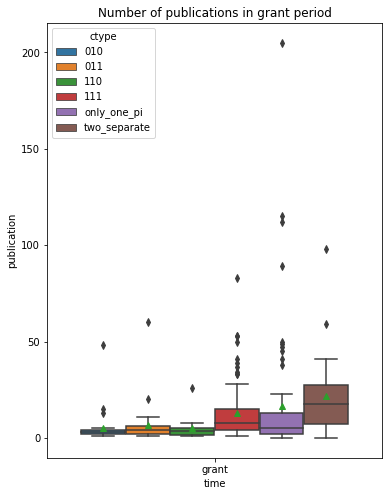

In [12]:
x = ["grant"]
ctype = ["010", "011", "110", "111", "only_one_pi", "two_separate"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_amount": [dict_amount[k] for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] if dict_publications[k][time] > 0 else 0 for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

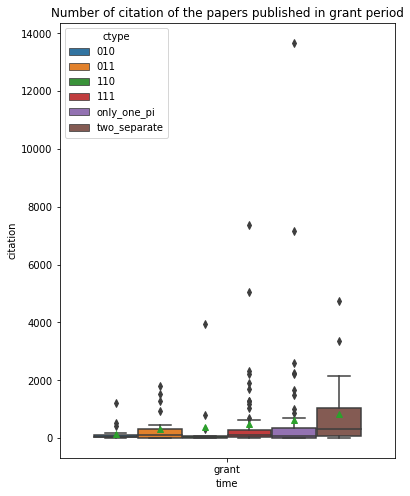

In [13]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

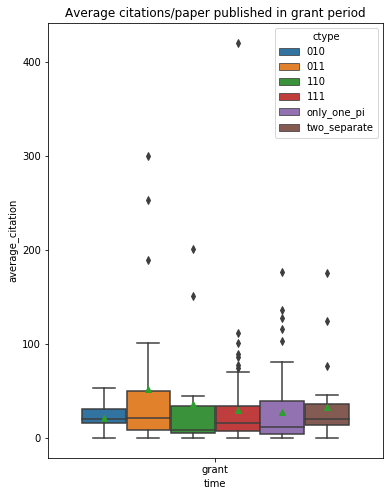

In [14]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

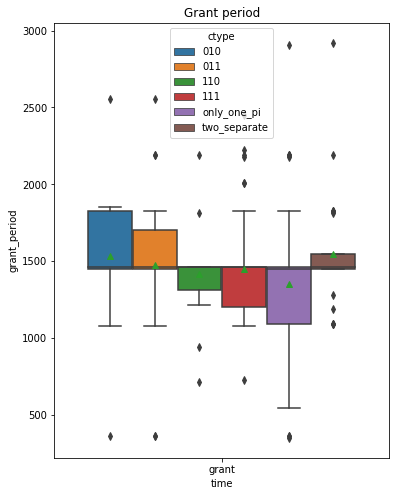

In [15]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

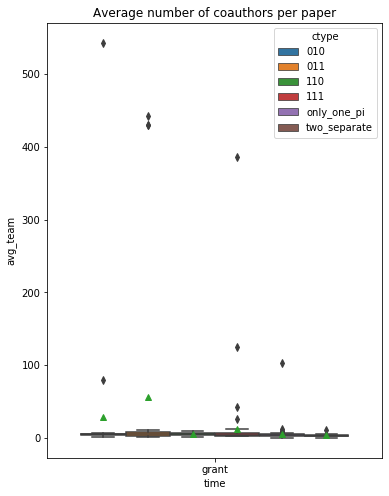

In [16]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

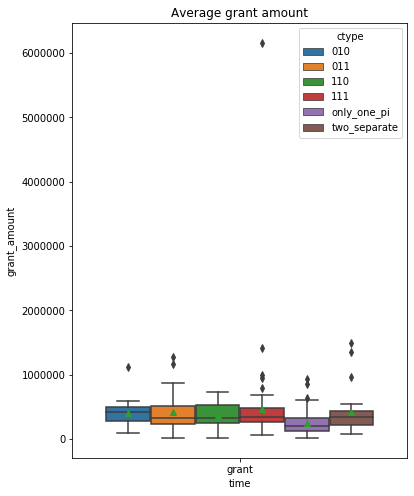

In [17]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_amount", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average grant amount")